In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.linalg import sqrtm

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver

In [37]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

In [38]:
range_model=np.array([[-1,1],[-1,1]])
clipped=np.clip(range_model,-1,1)
((range_model[:,1:]-range_model[:,:1]).T*np.random.rand(1000,2)+range_model[:,:1].T)

array([[ 0.16348054, -0.16125838],
       [ 0.52875503,  0.16606903],
       [-0.85465382, -0.00248841],
       ...,
       [-0.30096707,  0.98523758],
       [ 0.82619811, -0.85502672],
       [-0.64817325,  0.80641781]])

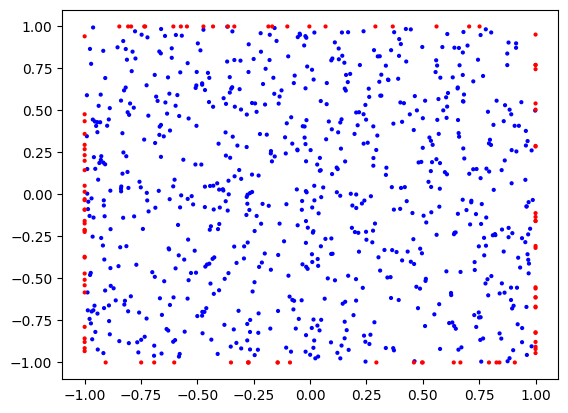

In [39]:
int_point_number=750
ext_point_number=100
X_int=make_points_inside(int_point_number)
X_boundary=make_points_boundary(ext_point_number)
X_all=np.concatenate([X_int,X_boundary])
plt.scatter(X_all[:,0],X_all[:,1],c=['b']*int_point_number+['r']*ext_point_number,s=4)

In [40]:
from sympy import cos,sin,pi,symbols,diff,lambdify

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=u_symbolic**3-laplacian(u_symbolic)
f_symbolic

cos(4*pi*x)**3*cos(pi*y/2)**3 + 65*pi**2*cos(4*pi*x)*cos(pi*y/2)/4

In [41]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2

In [42]:
u=PDESolver(X_int=X_int,X_boundary=X_boundary,sigma=0.1)
u.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 3.017e-07: : 4it [00:00,  6.27it/s]


In [43]:
def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

Current residual 1.007e+00: : 1it [22:35, 1355.68s/it]


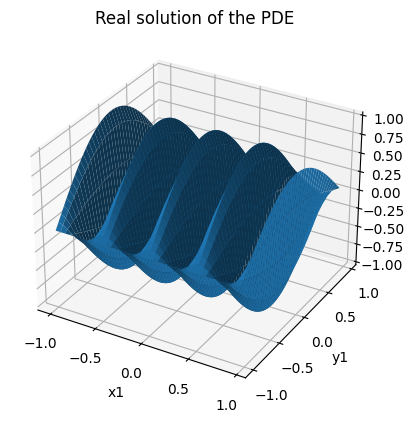

In [44]:
fig=plot_function(real_u)
plt.title('Real solution of the PDE')
plt.show()

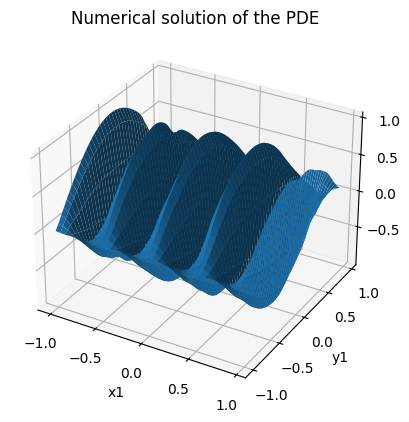

In [45]:
fig=plot_vectorized_function(u)
plt.title('Numerical solution of the PDE')
plt.show()

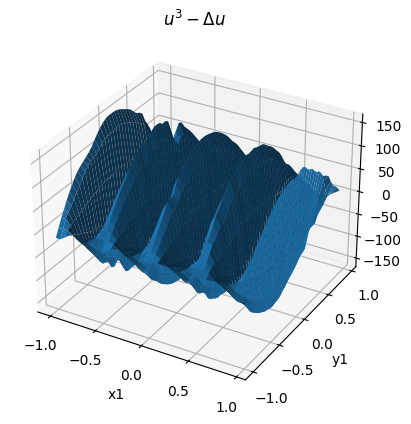

In [46]:
fig=plot_vectorized_function(lambda x:u(x)**3-u.laplacian(x))
#fig=plot_vectorized_function(lambda x:u.laplacian(x))
plt.title('$u^3-\Delta u$')
plt.show()

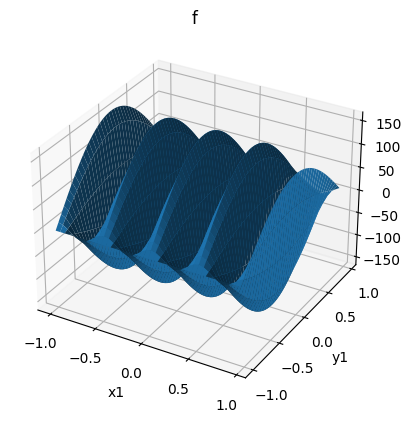

In [47]:
fig=plot_function(f)
plt.title('f')
plt.show()

In [48]:
X_int_left=make_points_inside(int_point_number)
X_int_right=make_points_inside(int_point_number)
X_boundary_left=make_points_boundary(ext_point_number)
X_boundary_right=make_points_boundary(ext_point_number)

In [49]:
sigma=3*(pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean()
print((pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean())
sigma=0.1

0.037621413357050826


In [50]:
u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<0.2],X_boundary=X_boundary_left,sigma=sigma,name='left')
u_left.fit(f,real_u,tau,dtau,nugget=1e-5)
u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right,sigma=sigma,name='right')
u_right.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 2.503e-07: : 5it [00:00, 22.54it/s]
Current residual 1.648e-07: : 5it [00:00, 20.04it/s]


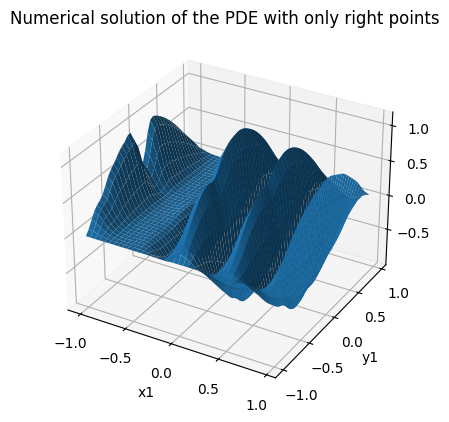

In [51]:
fig=plot_vectorized_function(u_right)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

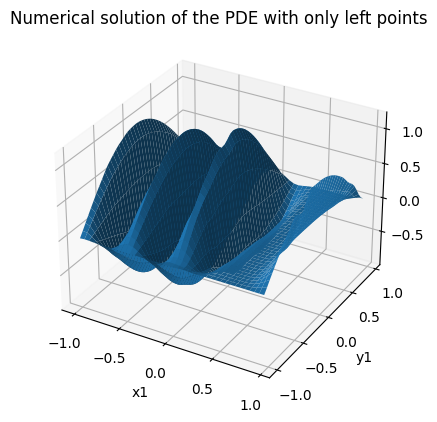

In [52]:
fig=plot_vectorized_function(u_left)
plt.title('Numerical solution of the PDE with only left points')
plt.show()

In [53]:
aggregate=Aggregate([u_left,u_right],sigma=sigma,nugget=1e-5)

M [[ 4.55591229e-03  1.01871343e-03]
 [ 1.11402204e-02  5.38548005e-05]
 [ 9.50703538e-03  8.96249257e-06]
 ...
 [ 1.15238682e-02 -1.85435239e-02]
 [ 2.15436874e-02  2.28533043e-02]
 [ 3.13485740e-02  5.27638063e-02]]
COV mat [[[0.99721984 0.98000609]
  [0.98000609 0.98290442]]

 [[0.99072665 0.99046187]
  [0.99046187 0.9999312 ]]

 [[0.9967996  0.99676048]
  [0.99676048 0.99999822]]

 ...

 [[0.0064111  0.00639493]
  [0.00639493 0.99988408]]

 [[0.020645   0.02062266]
  [0.02062266 0.99965687]]

 [[0.04365023 0.04363524]
  [0.04363524 0.99997023]]]
COV Y [[0.99720984 0.98289442]
 [0.99071665 0.9999212 ]
 [0.9967896  0.99998822]
 ...
 [0.0064011  0.99987408]
 [0.020635   0.99964687]
 [0.04364023 0.99996023]]
alpha [[8.56253704e-01 1.46260987e-01]
 [2.74440270e-02 9.72805867e-01]
 [1.19660363e-02 9.88062707e-01]
 ...
 [9.78577969e-04 9.99983740e-01]
 [6.20583814e-04 9.99977194e-01]
 [1.29978835e-04 9.99984328e-01]]


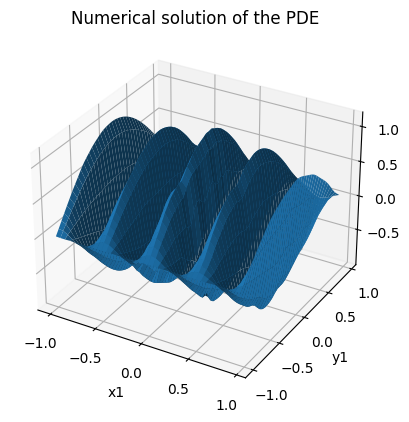

In [54]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [63]:
def prepare_B(model1,model2):

    K12=PDESolver.get_covariance_matrix(model1.X_all,model2.X_all,model1.Nd,model2.Nd,sigma,model1.nugget)
    K=np.block([[model1.K_mat,K12],[K12.T,model2.K_mat]])
    
    Kinv_1=model1.L.T@model1.L
    Kinv_2=model2.L.T@model2.L
    K1K2=np.block([[Kinv_1,np.zeros((Kinv_1.shape[0],Kinv_2.shape[1]))],[np.zeros((Kinv_2.shape[0],Kinv_1.shape[1])),Kinv_2]])
    K_half=sqrtm(K).real
    A=K_half@K1K2
    print(A)
    def big_k(x):
        k1x=PDESolver.get_kernel_vector(model1.X_all,model1.Nd,model1.sigma,x)
        k2x=PDESolver.get_kernel_vector(model2.X_all,model2.Nd,model2.sigma,x)

        return np.block([[k1x,np.zeros_like(k1x)],[np.zeros_like(k2x),k2x]])
    return lambda x:A@big_k(x),K_half,K1K2


In [101]:
def big_k(x):
        k1x=PDESolver.get_kernel_vector(u_left.X_all,u_left.Nd,u_left.sigma,x)
        k2x=PDESolver.get_kernel_vector(u_right.X_all,u_right.Nd,u_right.sigma,x)

        return np.block([[k1x,np.zeros_like(k1x)],[np.zeros_like(k2x),k2x]])

In [64]:
B,K_half,K1K2=prepare_B(u_left,u_right)

[[ 2.53474995e+02 -4.84203428e+01 -2.45306493e-01 ... -2.73072823e-03
  -3.14697229e-05 -1.32455312e-05]
 [-4.74683691e+01  1.84920355e+02 -2.84658412e-01 ... -3.35720589e-03
  -6.02489360e-05 -2.73493926e-05]
 [-4.12299870e-01 -1.61160608e-01  2.42346295e+02 ...  1.24400709e-02
  -3.48825885e-04 -3.91035266e-05]
 ...
 [ 2.08221931e-01 -9.28265621e-02  1.25819303e+00 ...  2.19576855e-01
  -1.28957218e-03 -1.48345478e-04]
 [-1.48643919e-03 -1.15912674e-03 -1.95807952e-02 ...  4.97149978e-03
   1.54524957e-01  1.30615826e-03]
 [-2.17977323e-03 -3.53170825e-03  1.40760614e-01 ...  5.01182228e-02
   1.66085023e-02 -5.92285543e-03]]


In [99]:
K=K_half@K_half

In [100]:
K_for_alpha=K@K1K2

In [116]:
x_to_test=np.array([[-0.7,0.6]])

In [117]:
b=B(x_to_test)
eigenvectors = np.linalg.eig(b@np.linalg.pinv(b))[1].real

In [118]:
alpha_mat = np.linalg.pinv(b)@np.linalg.inv(K_half@K1K2@K_half)@b
print(alpha_mat)

[[ 1.00012355e+00 -1.23544958e-04]
 [-1.00016733e+00  1.00012355e+00]]


In [119]:
alpha_inv_mat = np.linalg.pinv(big_k(x_to_test))@K_for_alpha@big_k(x_to_test)
print(alpha_inv_mat)

[[ 1.         -0.00117937]
 [ 1.00067945  1.        ]]


In [124]:
alpha_inv_mat@alpha_mat

array([[ 1.00130312e+00, -1.30306129e-03],
       [ 6.35754650e-04,  9.99999918e-01]])

In [121]:
np.linalg.solve(np.linalg.pinv(big_k(x_to_test))@K_for_alpha@big_k(x_to_test),np.ones(2))

array([ 9.99999200e-01, -6.78652356e-04])

In [122]:
aggregate.alpha(x_to_test)

COV mat [[[9.99995984e-01 1.23527759e-04]
  [1.23527759e-04 1.33522539e-04]]]
COV Y [[9.99985984e-01 1.23522539e-04]]


array([[ 9.99990004e-01, -2.98421544e-05]])

In [123]:
half_eigenvalues,half_eigenvectors=np.linalg.eigh(K_half)
half_eigenvectors[:,1]

array([ 2.05443063e-02, -1.70892941e-04,  6.68701093e-03, ...,
        4.29476744e-05, -1.89900133e-06,  1.28357515e-06])

In [83]:
half_eigenvalues

array([3.16227471e-03, 3.16227482e-03, 3.16227498e-03, ...,
       8.72913860e+02, 9.13730838e+02, 9.43401883e+02])

In [89]:
print(np.linalg.norm(K_half@eigenvectors[:,0]))
print(np.dot(eigenvectors[:,0],K_half@eigenvectors[:,0]))
print(np.dot(eigenvectors[:,50],K_half@eigenvectors[:,0]))

362.12685498892193
314.57508623804426
1.048659576335476


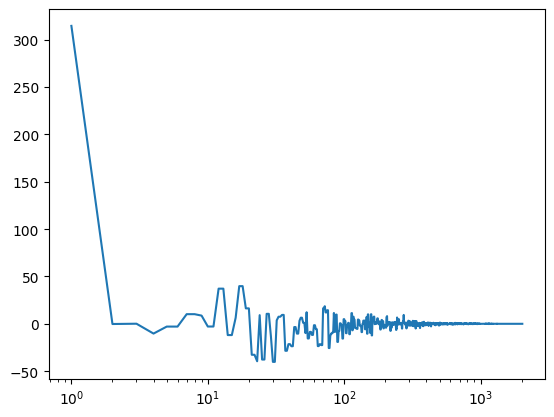

In [94]:
plt.plot(range(1,1+half_eigenvectors.shape[0]),eigenvectors.T@(K_half@eigenvectors[:,0]))
plt.xscale('log')

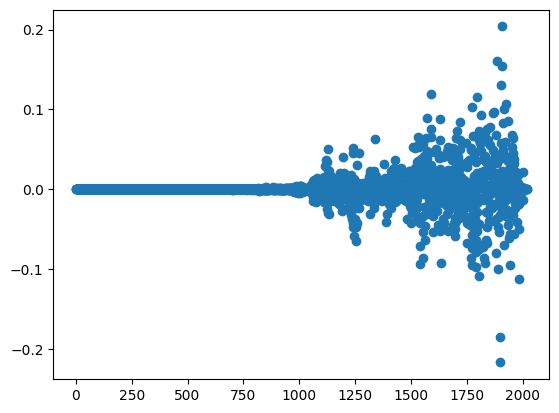

In [80]:
plt.scatter(range(half_eigenvectors.shape[0]),half_eigenvectors.T@eigenvectors[:,0])

In [72]:
np.dot(eigenvectors[5],K_half@eigenvectors[0])

0.002171600755284215

In [57]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U = u(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))


M [[3.74145914e-05 3.47773796e-05]
 [2.48573496e-05 1.84317139e-05]
 [7.78984948e-06 8.51700060e-06]
 ...
 [1.50152352e-02 1.45732622e-02]
 [1.53953177e-02 1.51794475e-02]
 [1.56281310e-02 1.55452904e-02]]
COV mat [[[0.99979814 0.99989744]
  [0.99989744 0.99999963]]

 [[1.00052076 1.00025739]
  [1.00025739 0.99999942]]

 [[1.00029638 1.00014654]
  [1.00014654 0.99999952]]

 ...

 [[0.99914288 0.99915444]
  [0.99915444 1.0000237 ]]

 [[0.99960911 0.9995767 ]
  [0.9995767  0.99993437]]

 [[0.99990035 0.99987257]
  [0.99987257 0.99994365]]]
COV Y [[0.99979814 0.99999963]
 [1.00052076 0.99999942]
 [1.00029638 0.99999952]
 ...
 [0.99914288 1.0000237 ]
 [0.99960911 0.99993437]
 [0.99990035 0.99994365]]
alpha [[-3.43784101e+01  3.53748968e+01]
 [ 4.93763716e+01 -4.83891093e+01]
 [ 5.33989042e+01 -5.24067546e+01]
 ...
 [-1.34857650e-02  1.01347404e+00]
 [ 8.31192856e-02  9.16910446e-01]
 [ 2.80995221e-01  7.19024753e-01]]


In [58]:
np.linalg.norm(U-U_real,ord=np.inf)

0.00025127529675872395

In [59]:
x_sample=np.array([[-0.7,-0.6]])
print(real_u(x_sample[0]))
aggregate(x_sample)

-0.47552825814757677
M [[-0.46778205  0.00714734]]
COV mat [[[1.00294756e+00 1.25636888e-04]
  [1.25636888e-04 1.28083518e-04]]]
COV Y [[1.00294756e+00 1.28083518e-04]]
alpha [[0.99999761 0.01910419]]


array([-0.46764438])

In [60]:
u_left.covariate_with_sol(x_sample)

array([1.])

In [61]:
u_left.sigma

0.1

In [62]:
u_left.covariate_with_sol(x_sample,0.1)

array([1.00294756])

In [63]:
aggregate.alpha(x_sample)

COV mat [[[1.00294756e+00 1.25636888e-04]
  [1.25636888e-04 1.28083518e-04]]]
COV Y [[1.00294756e+00 1.28083518e-04]]


array([[0.99999761, 0.01910419]])

In [64]:
u_left.covariate_with_other(u_left,x_sample,1e-6)

array([1.6939651e+21])

In [70]:
#cov_left=u_left.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
#cov_right=u_right.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
#cov_inter=u_right.covariate_with_other(u_left,np.stack([X.flatten(),Y.flatten()],axis=-1),sigma=0.1)
alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))

COV mat [[[1.00000316 0.99995398]
  [0.99995398 0.99997043]]

 [[1.00000572 0.9999674 ]
  [0.9999674  0.99998138]]

 [[1.00000593 0.9999697 ]
  [0.9999697  0.99998334]]

 ...

 [[0.99912892 0.99911923]
  [0.99911923 1.00001207]]

 [[0.99959631 0.99958658]
  [0.99958658 1.00001139]]

 [[0.99989525 0.99988478]
  [0.99988478 1.00001053]]]
COV Y [[0.99999316 0.99996043]
 [0.99999572 0.99997138]
 [0.99999593 0.99997334]
 ...
 [0.99911892 1.00000207]
 [0.99958631 1.00000139]
 [0.99988525 1.00000053]]


In [71]:
np.max(np.abs(np.sum(alpha,axis=-1)-1))

0.00018604913158193348

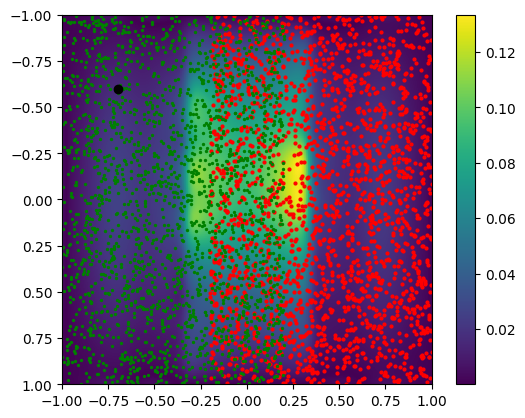

In [29]:
ax=plt.subplot()
im = ax.imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
ax.scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
ax.scatter(x_sample[:,0],x_sample[:,1],c='k')
plt.colorbar(im)

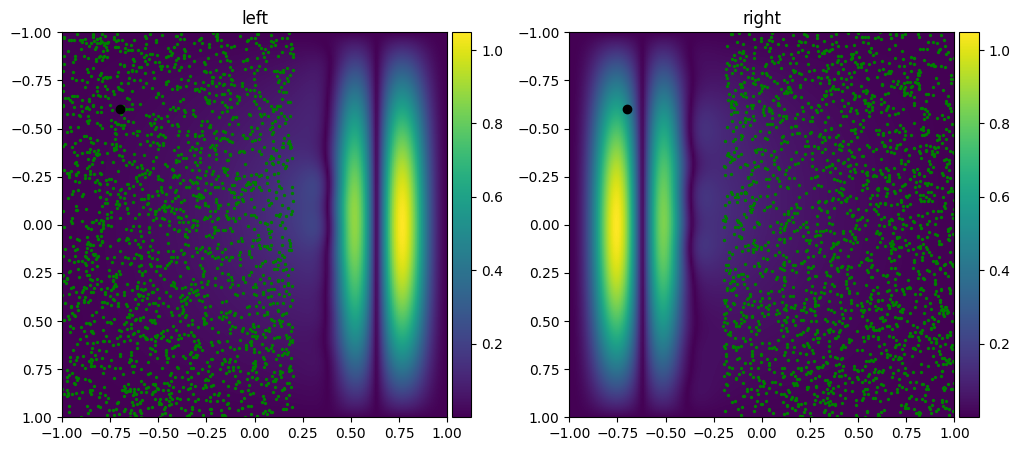

In [30]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.abs(U_left-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U_right-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

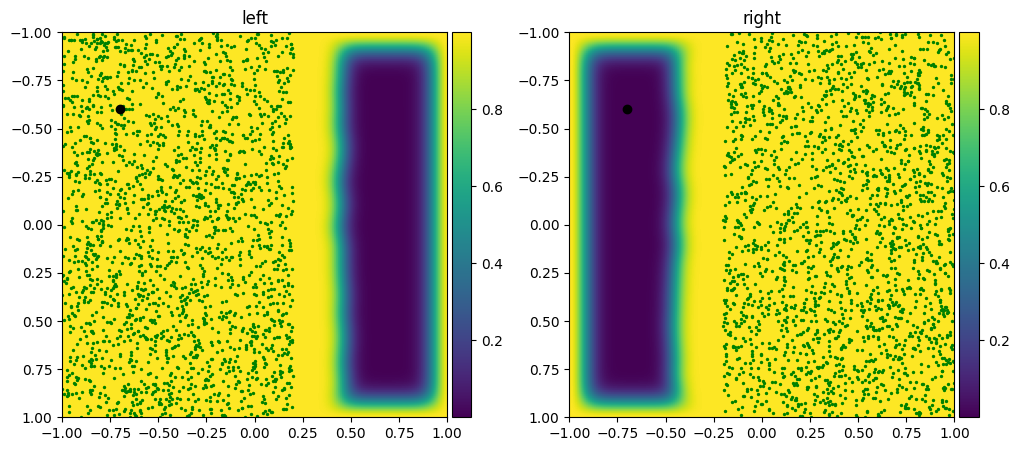

In [31]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(cov_left.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(cov_right.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

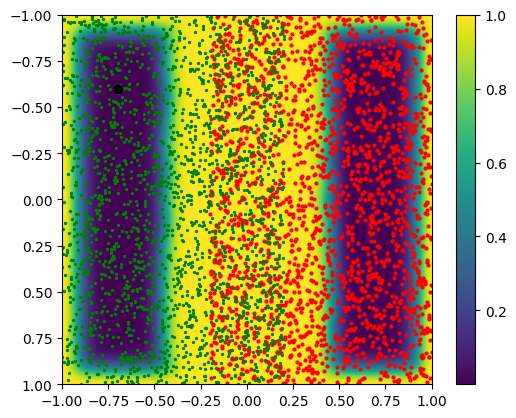

In [32]:
ax=plt.subplot()
im = ax.imshow(cov_inter.reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
ax.scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
ax.scatter(x_sample[:,0],x_sample[:,1],c='k')
plt.colorbar(im)

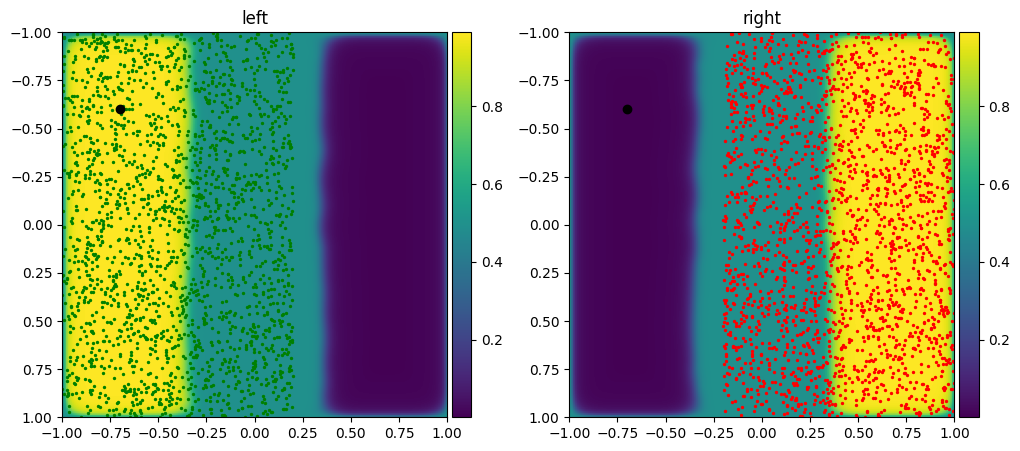

In [33]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha[:,0].reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(alpha[:,1].reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [34]:
def make_an_aggregate(N_int,N_boundary):
    X_int_left=make_points_inside(N_int)
    X_int_right=make_points_inside(N_int)
    X_boundary_left=make_points_boundary(N_boundary)
    X_boundary_right=make_points_boundary(N_boundary)
    sigma=3*(pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean()
    u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<0.2],X_boundary=X_boundary_left[X_boundary_left[:,0]<0.2],sigma=sigma,name='left')
    u_left.fit(f,real_u,tau,dtau,nugget=1e-5)
    u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right[X_boundary_right[:,0]>-0.2],sigma=sigma,name='right')
    u_right.fit(f,real_u,tau,dtau,nugget=1e-5)

    aggregate=Aggregate([u_left,u_right],sigma=sigma,nugget=1e-4)
    return u_left,u_right,aggregate

def get_error(aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    return np.linalg.norm(U_real-U_agg),np.linalg.norm(U_real-U_agg,ord=np.inf)

def make_plot(u_left,u_right,aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))
    alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))


    fig,axes=plt.subplots(3,2,figsize=(30,30))
    im = axes[0,0].imshow(np.abs(U_left-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[0,0].title.set_text('error of left model')

    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im2 = axes[0,1].imshow(np.abs(U_right-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=4)
    axes[0,1].title.set_text('error of right model')

    divider = make_axes_locatable(axes[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')


    im3 = axes[1,0].imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,0].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[1,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=6)
    axes[1,0].title.set_text('error of aggregate')
    divider = make_axes_locatable(axes[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    im4 = axes[1,1].imshow(np.abs(U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,1].title.set_text('absolute value of solution')
    divider = make_axes_locatable(axes[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical')

    im5 = axes[2,0].imshow(alpha[:,0].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[2,0].title.set_text('alpha left')

    divider = make_axes_locatable(axes[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical')

    im6 = axes[2,1].imshow(alpha[:,1].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[2,1].title.set_text('alpha right')

    divider = make_axes_locatable(axes[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical')

    plt.show()

    


In [35]:
u_left,u_right,aggregate=make_an_aggregate(N_int=10000,N_boundary=1000)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
make_plot(u_left,u_right,aggregate)

M [[ 5.15761422e-004 -6.19552716e-157]
 [ 1.14283268e-004 -4.32371226e-153]
 [ 9.51213397e-006 -2.69854607e-149]
 ...
 [ 9.36268389e-146  1.51252445e-002]
 [ 1.64241378e-149  1.56403057e-002]
 [ 2.57665629e-153  1.59235209e-002]]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/theobourdais/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_79419/3635802386.py", line 1, in <module>
    make_plot(u_left,u_right,aggregate)
  File "/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_79419/3864932853.py", line 26, in make_plot
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 174, in __call__
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 166, in alpha
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 154, in inner_models_cov_matrix
    covs=np.array(list(map(lambda model_pair:Aggregate.covariate_models(model_pair[0],model

# Local convergence

In [ ]:
X_local=make_points_inside(Nd=2000,range=np.array[[-0.2,0.1],[-0.2,0.1]])
X_boundary_local=make_points_boundary(200)
u_local=PDESolver(X_int=X_local,X_boundary=X_boundary_local,sigma=0.1,name='local')
u_local.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 3.468e-07: : 8it [00:24,  3.05s/it]


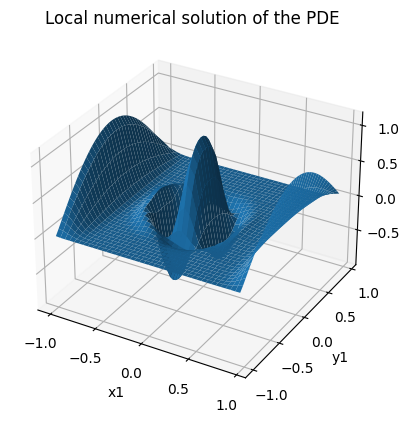

In [ ]:
fig=plot_vectorized_function(u_local)
plt.title('Local numerical solution of the PDE ')
plt.show()

In [ ]:
x = y = np.arange(-0.2, 0.1, 0.1)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U = u(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_loc= u_local(np.stack([X.flatten(),Y.flatten()],axis=-1))

In [ ]:
np.linalg.norm(U_real-U_loc,ord=np.inf)

0.45111099011852623

# Aggregating many models

In [ ]:
def aggregate_many_models(N_models,N_points_inside,buffer_size,sigma,nugget_aggregate,nugget_model=1e-5):
    models=[]
    for k in range(N_models**2):
        kx=k%N_models
        ky=k//N_models
        range_model=np.array([
            [-1+kx/N_models*2-buffer_size,-1+(kx+1)/N_models*2+buffer_size],
            [-1+ky/N_models*2-buffer_size,-1+(ky+1)/N_models*2+buffer_size]
            ])
        models.append(PDESolver(X_int=make_points_inside(Nd=N_points_inside,range_model=range_model),
                  X_boundary=make_points_boundary(N_points_inside//10),
                  sigma=sigma,
                  name=f'model_{k}'))
        models[-1].fit(f,real_u,tau,dtau,nugget=nugget_model)
    return Aggregate(models,sigma=sigma,nugget=nugget_aggregate)


In [ ]:
big_aggregate=aggregate_many_models(N_models=3,N_points_inside=1000,buffer_size=0.0,sigma=0.1,nugget_aggregate=1e-5,nugget_model=1e-5)

Current residual 5.455e-07: : 6it [00:02,  2.56it/s]
Current residual 5.581e-08: : 8it [00:02,  3.57it/s]
Current residual 4.520e-07: : 6it [00:01,  3.65it/s]
Current residual 1.046e-07: : 8it [00:02,  3.96it/s]
Current residual 7.935e-07: : 7it [00:01,  3.84it/s]
Current residual 1.380e-07: : 8it [00:02,  3.93it/s]
Current residual 3.346e-08: : 8it [00:02,  3.96it/s]
Current residual 9.670e-08: : 8it [00:02,  3.96it/s]
Current residual 4.454e-07: : 6it [00:01,  3.97it/s]


M [[-6.44743135e-05  1.49632773e-03  7.69889068e-03 ...  3.15626711e-02
   1.68221862e-03  5.40859219e-05]
 [ 8.62946725e-05  2.31462567e-04  1.37849915e-05 ...  1.24694655e-02
   9.25304273e-04 -3.74160991e-06]
 [ 6.39353630e-06  4.06071789e-03  3.38699879e-04 ...  3.45618462e-04
   2.23522810e-04 -1.33821909e-08]
 ...
 [ 2.36029530e-02  2.58414259e-02  2.38072073e-02 ...  1.05448737e-02
   1.99381982e-02 -2.17715570e-02]
 [ 4.63624722e-02  4.82870212e-02  4.44039922e-02 ...  1.92191277e-02
   3.98146955e-02  2.59206785e-02]
 [ 6.90015124e-02  7.03189159e-02  6.50138375e-02 ...  2.83856813e-02
   6.38675378e-02  6.43434542e-02]]
COV mat [[[1.00000937 0.99954936 0.98994814 ... 0.72674018 0.99955435 0.99958647]
  [0.99954936 0.99956151 0.99017586 ... 0.72733701 0.9993006  0.99916734]
  [0.98994814 0.99017586 0.98995843 ... 0.72467289 0.98996025 0.99009999]
  ...
  [0.72674018 0.72733701 0.72467289 ... 0.7267482  0.72692423 0.72619792]
  [0.99955435 0.9993006  0.98996025 ... 0.72692423 0

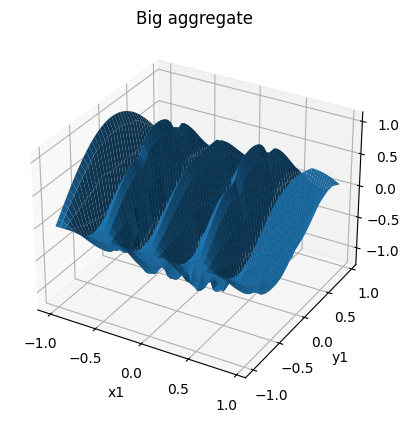

In [ ]:
fig=plot_vectorized_function(big_aggregate)
plt.title('Big aggregate')
plt.show()

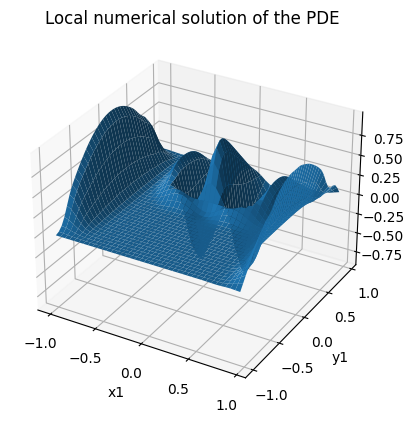

In [ ]:
fig=plot_vectorized_function(big_aggregate.models[7])
plt.title('Local numerical solution of the PDE ')
plt.show()

In [ ]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U_agg= big_aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha=big_aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)

M [[-6.44743135e-05  1.49632773e-03  7.69889068e-03 ...  3.15626711e-02
   1.68221862e-03  5.40859219e-05]
 [-5.30114289e-06  7.20107961e-04  5.09781792e-03 ...  2.79305293e-02
   1.55929459e-03  2.31944138e-05]
 [ 3.95049860e-05  1.94267468e-04  3.04552986e-03 ...  2.40557793e-02
   1.41689285e-03  5.01350261e-06]
 ...
 [ 2.73166306e-02  1.45264015e-02  1.45791163e-02 ...  4.56649106e-03
   2.37662240e-02  1.47107671e-02]
 [ 2.81615178e-02  1.49207493e-02  1.60213334e-02 ...  4.99739577e-03
   2.56228630e-02  1.52717620e-02]
 [ 2.87157494e-02  1.51746435e-02  1.76333821e-02 ...  5.41917753e-03
   2.72032997e-02  1.55914143e-02]]
COV mat [[[1.00000937 0.99954936 0.98994814 ... 0.72674018 0.99955435 0.99958647]
  [0.99954936 0.99956151 0.99017586 ... 0.72733701 0.9993006  0.99916734]
  [0.98994814 0.99017586 0.98995843 ... 0.72467289 0.98996025 0.99009999]
  ...
  [0.72674018 0.72733701 0.72467289 ... 0.7267482  0.72692423 0.72619792]
  [0.99955435 0.9993006  0.98996025 ... 0.72692423 0

In [ ]:
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)

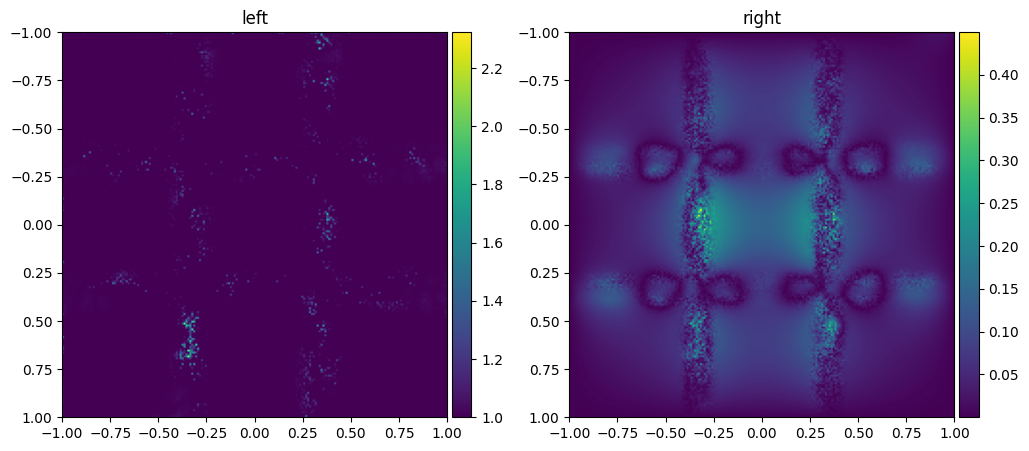

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha_norm.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(error_big_agg.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')